# Cell Direction for Training

In [1]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt
import inspect
import importlib

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader
from mpl_toolkits.mplot3d import Axes3D

from itertools import chain
from random import shuffle, sample

from torch.nn import Linear
import torch.nn.functional as F
from torch_scatter import scatter, segment_csr, scatter_add
from torch_geometric.nn.conv import MessagePassing
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
from itertools import permutations
import itertools
import plotly.express as px

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from sklearn.cluster import DBSCAN
from sklearn import metrics

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from prepare_utils import *
from performance_utils import *
from toy_utils import *
from models import *
from trainers import *
%matplotlib inline


# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import wandb
import faiss
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
torch_seed = 0

In [61]:
importlib.reload(sys.modules['toy_utils'])
from toy_utils import *

In [43]:
importlib.reload(sys.modules['models'])
from models import *

## Data Preparation

### Construct Truth with Primary Vertex

In [441]:
def select_hits(hits, truth, particles, pt_min=0, endcaps=False, noise=False):
    # Barrel volume and layer ids
    if endcaps:
        vlids = [(7, 2), (7, 4), (7, 6), (7, 8), (7, 10), (7, 12), (7, 14), (8, 2), (8, 4), (8, 6), (8, 8), (9, 2), (9, 4), (9, 6), (9, 8), (9, 10), (9, 12), (9, 14), (12, 2), (12, 4), (12, 6), (12, 8), (12, 10), (12, 12), (13, 2), (13, 4), (13, 6), (13, 8), (14, 2), (14, 4), (14, 6), (14, 8), (14, 10), (14, 12), (16, 2), (16, 4), (16, 6), (16, 8), (16, 10), (16, 12), (17, 2), (17, 4), (18, 2), (18, 4), (18, 6), (18, 8), (18, 10), (18, 12)]
    else:
        vlids = [(8,2), (8,4), (8,6), (8,8), (13,2), (13,4), (13,6), (13,8), (17,2), (17,4)]
    n_det_layers = len(vlids)
    # Select barrel layers and assign convenient layer number [0-9]
    vlid_groups = hits.groupby(['volume_id', 'layer_id'])
    hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                      for i in range(n_det_layers)])
    if noise is False:
        # Calculate particle transverse momentum
        pt = np.sqrt(particles.px**2 + particles.py**2)
        particles = particles.assign(pt=pt)
        # Applies pt cut, removes noise hits
        particles = particles[pt > pt_min]
        truth = (truth[['hit_id', 'particle_id']]
                 .merge(particles[['particle_id', 'pt', 'vx', 'vy', 'vz']], on='particle_id'))
    else:
        # Calculate particle transverse momentum
        pt = np.sqrt(truth.tpx**2 + truth.tpy**2)
        # Applies pt cut
        truth = truth[pt > pt_min]
        truth.loc[truth['particle_id'] == 0,'particle_id'] = float('NaN')
    # Calculate derived hits variables
    r = np.sqrt(hits.x**2 + hits.y**2)
    phi = np.arctan2(hits.y, hits.x)
    # Select the data columns we need
    hits = (hits[['hit_id', 'x', 'y', 'z', 'layer']]
            .assign(r=r, phi=phi)
            .merge(truth[['hit_id', 'particle_id', 'pt', 'vx', 'vy', 'vz']], on='hit_id'))
    # (DON'T) Remove duplicate hits
#     hits = hits.loc[
#         hits.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()
#     ]
    return hits

In [339]:
input_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all"
all_files = os.listdir(input_dir)
all_events = sorted(np.unique([os.path.join(input_dir, event[:14]) for event in all_files]))

In [442]:
%%time
hits, particles, truth = trackml.dataset.load_event(
        all_events[0], parts=['hits', 'particles', 'truth'])
hits = select_hits(hits, truth, particles, pt_min=0, endcaps=True, noise=False)

hits = hits.assign(R=np.sqrt((hits.x - hits.vx)**2 + (hits.y - hits.vy)**2 + (hits.z - hits.vz)**2))
hits = hits.sort_values('R').reset_index(drop=True).reset_index(drop=False)
layers = hits.layer.to_numpy()
hit_list = hits.groupby(['particle_id', 'layer'], sort=False)['index'].agg(lambda x: list(x)).groupby(level=0).agg(lambda x: list(x))

e = []
for row in hit_list.values:
    for i, j in zip(row[0:-1], row[1:]):
        e.extend(list(itertools.product(i, j)))

true_edges = np.array(e).T
print("Edges built for", all_events[0], "with size", true_edges.shape)


Exception: No file matches '/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/0_pt_cut_endcaps/all_events/1002-hits.csv*'

In [404]:
hits[(hits.pt < 0.2) & (hits.vx > 0.1) ][::100]

,index,hit_id,x,y,z,layer,r,phi,particle_id,pt,vx,vy,vz,R
6,6,39492,115.622002,-1.804990,383.661987,9,115.636086,-0.015610,707073800168022018,0.154458,115.622002,-1.804870,383.660004,0.001987
632,632,24870,30.167601,13.420400,163.932999,7,33.018044,0.418572,225182180408569858,0.191786,18.940399,-1.504040,174.276001,21.348692
5168,5168,19201,-31.920500,-5.461630,-63.358799,7,32.384373,-2.972133,153149600243384320,0.117173,8.882250,-16.755501,-10.064100,68.064240
9807,9807,44340,74.039597,-156.229996,205.143997,10,172.886307,-1.128234,90086698515431424,0.169954,7.955480,-73.460800,176.589005,109.696114
14816,14816,33208,-35.719601,61.892300,488.481995,8,71.460106,2.094226,225190632904200193,0.166334,16.734800,-63.431000,570.568970,158.731430
19517,19517,38527,-109.536003,40.385899,141.432999,9,116.743980,2.788357,153136406120632321,0.186906,12.327500,-14.458000,302.074005,208.959564
23436,23436,76670,117.126999,-237.371994,460.600006,24,264.696411,-1.112417,112590815334764545,0.181857,35.414902,-11.549200,570.568970,264.132507
27896,27896,67386,207.302994,-268.584991,-1795.500000,21,339.282227,-0.913467,292742978047320066,0.100771,251.561005,-408.933990,-1504.500000,326.094482
31579,31579,15710,57.307301,41.613400,-602.500000,6,70.822327,0.628058,27037334524395520,0.184054,8.475260,13.848700,-221.126999,385.487762
34917,34917,74888,18.468599,261.170013,-51.799999,24,261.822205,1.500199,220706274730323970,0.156210,16.203501,-27.681601,296.881989,452.790802


In [405]:
pid = 112594182589124609
sample_e = true_edges[:, hits.iloc[true_edges[0]].particle_id == pid]
sample = hits[hits.particle_id == pid]

In [406]:
sample_e

array([[   313,  15499,  15499,  29023,  29310,  38926,  64943],
       [ 15499,  29023,  29310,  38926,  38926,  64943, 103300]])

In [407]:
sample

,index,hit_id,x,y,z,layer,r,phi,particle_id,pt,vx,vy,vz,R
313,313,55863,18.987400,-69.523201,957.500000,14,72.069389,-1.304189,112594182589124609,0.157509,19.479601,-66.294403,962.5,5.972219
15499,15499,52961,19.627600,-158.619995,822.000000,13,159.829742,-1.447682,112594182589124609,0.157509,19.479601,-66.294403,962.5,168.119858
29023,29023,77560,53.819500,-251.917999,669.400024,24,257.602844,-1.360321,112594182589124609,0.157509,19.479601,-66.294403,962.5,348.630096
29310,29310,77286,55.476299,-254.753006,664.200012,24,260.723450,-1.356379,112594182589124609,0.157509,19.479601,-66.294403,962.5,354.676331
38926,38926,83722,125.630997,-334.072998,503.000000,25,356.914429,-1.211098,112594182589124609,0.157509,19.479601,-66.294403,962.5,542.322571
64943,64943,89048,320.518005,-383.178986,187.475006,26,499.557739,-0.874209,112594182589124609,0.157509,19.479601,-66.294403,962.5,889.777344
103300,103300,104923,625.539978,-441.858002,-2944.500000,34,765.858154,-0.614983,112594182589124609,0.157509,19.479601,-66.294403,962.5,3971.524414


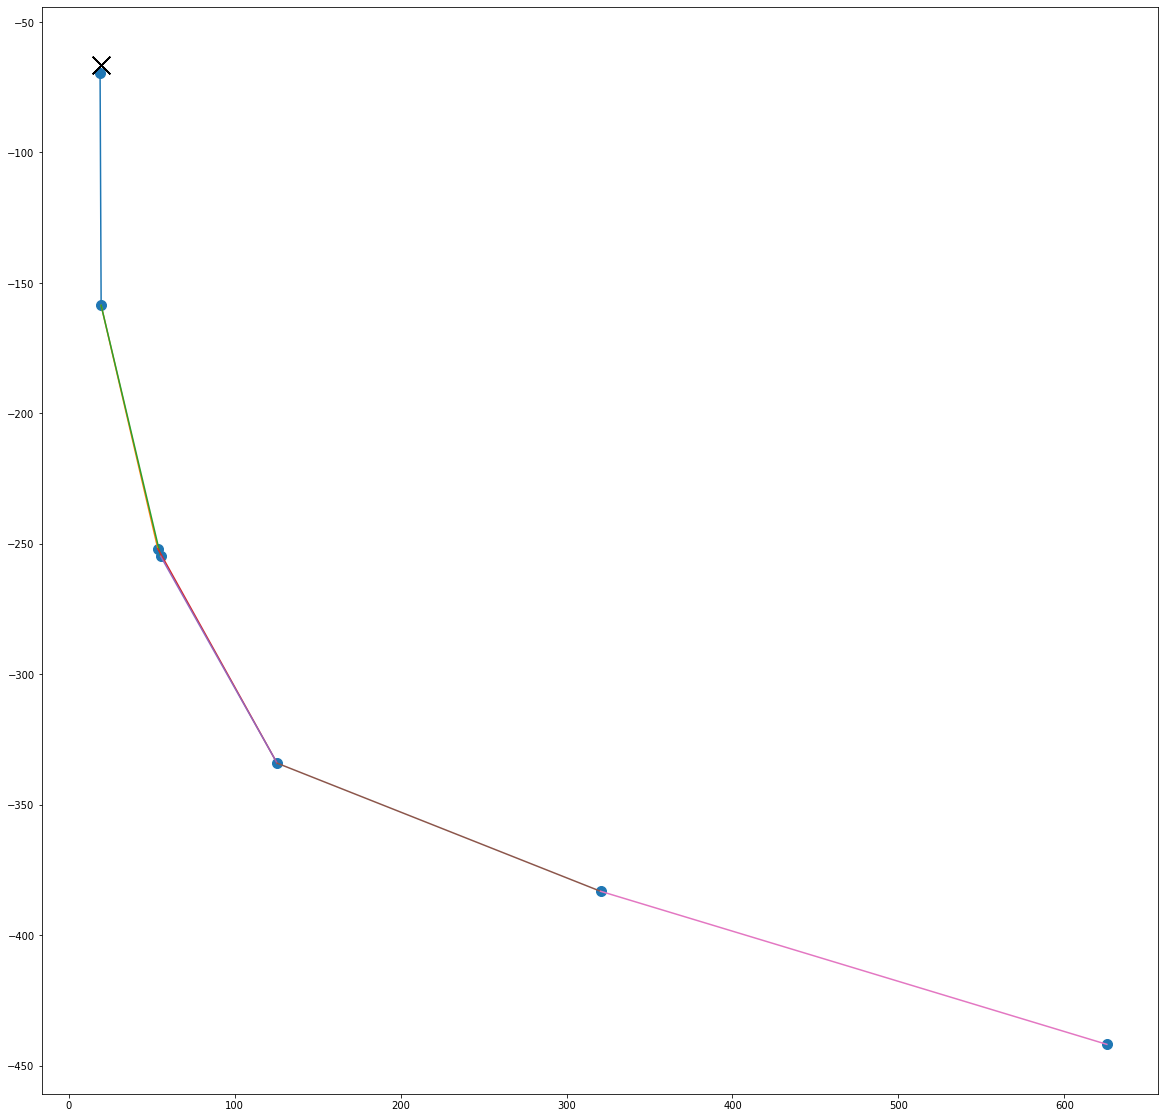

In [408]:
plt.figure(figsize=[20,20])
# plt.scatter(hits.x, hits.y, s=1)
plt.scatter(sample.x, sample.y, s=100)
plt.scatter(sample.vx, sample.vy, s=300, marker='x', c='k')
plt.plot([sample.x[sample_e[0]], sample.x[sample_e[1]]], [sample.y[sample_e[0]], sample.y[sample_e[1]]]);

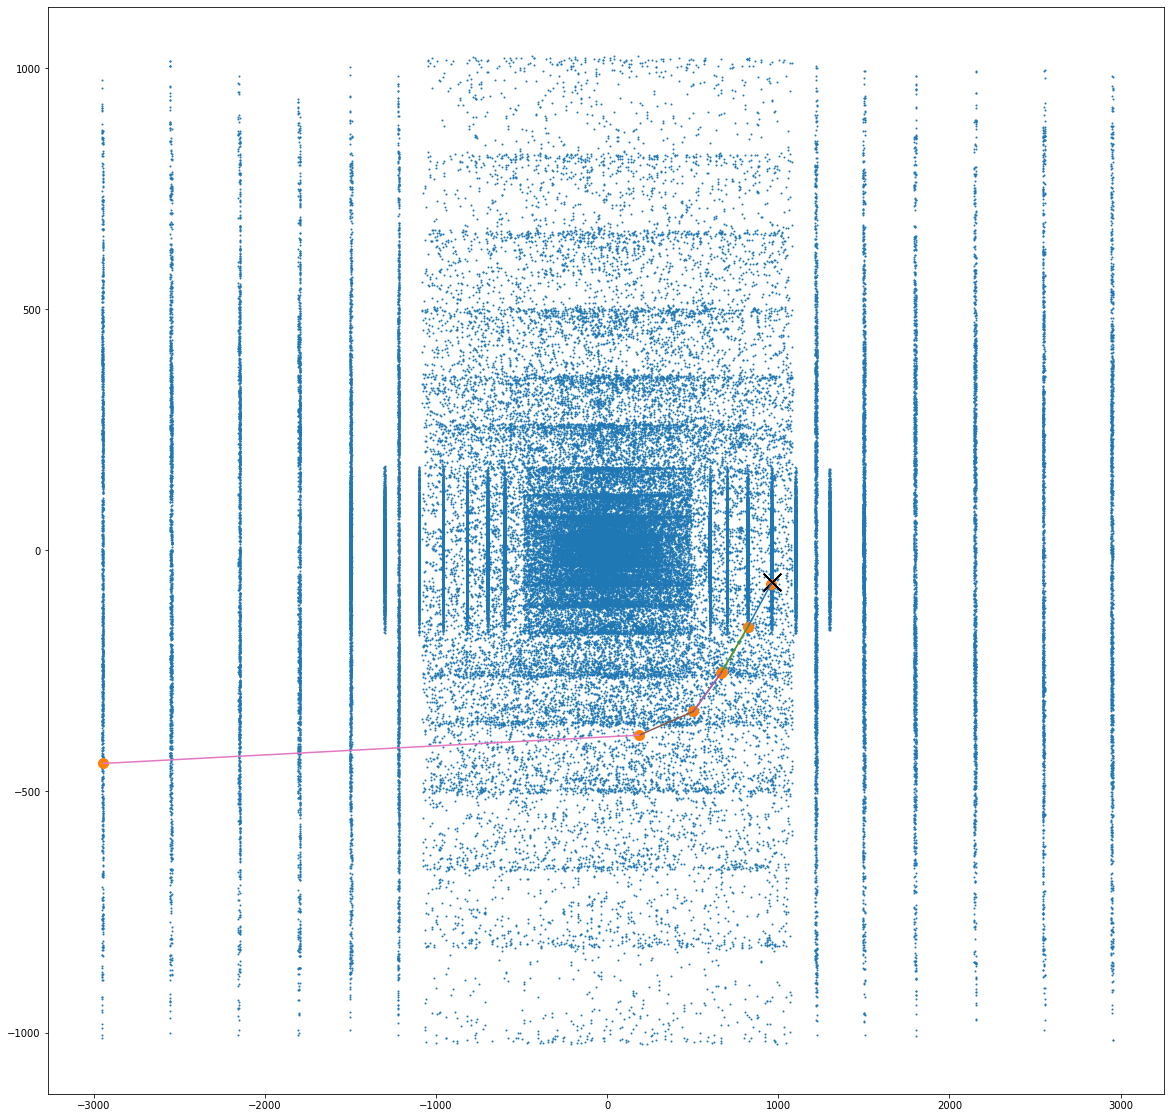

In [409]:
plt.figure(figsize=[20,20])
plt.scatter(hits.z, hits.y, s=1)
plt.scatter(sample.z, sample.y, s=100)
plt.scatter(sample.vz, sample.vy, s=300, marker='x', c='k')
plt.plot([sample.z[sample_e[0]], sample.z[sample_e[1]]], [sample.y[sample_e[0]], sample.y[sample_e[1]]]);

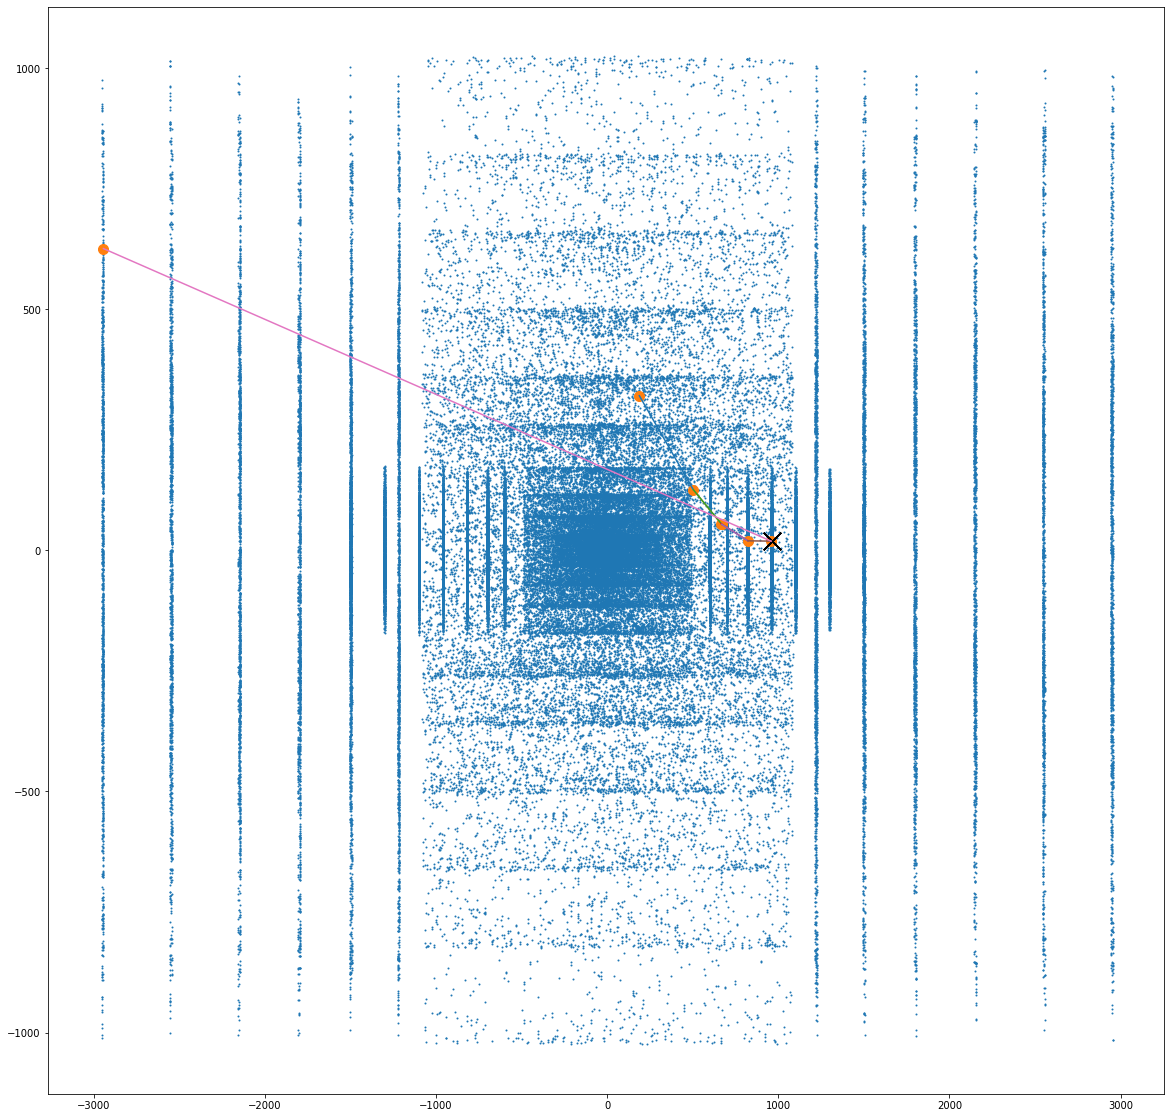

In [399]:
plt.figure(figsize=[20,20])
plt.scatter(hits.z, hits.y, s=1)
plt.scatter(sample.z, sample.x, s=100)
plt.scatter(sample.vz, sample.vx, s=300, marker='x', c='k')
plt.plot([sample.z[sample_e[0]], sample.z[sample_e[1]]], [sample.x[sample_e[0]], sample.x[sample_e[1]]]);

### Prepare Filter Candidates

In [6]:
pt_cut = 0
train_number = 1000
test_number = 100

In [7]:
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/filter_processed/"
# basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut_endcaps")
basename = os.path.join(save_dir, "1000_train_events")

In [ ]:
%%time
for i, batch in enumerate(train_dataset):
    if not os.path.exists(os.path.join(basename, batch.event_file[-4:])):
                
        data = batch.x.to(device)
        spatial = model(data)

        e_spatial = build_edges(spatial, 1.6, 1024, res)

        # Get the truth graphs
        e_bidir_layerless = torch.cat([batch.layerless_true_edges, 
                                   torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T], axis=-1) 

        array_size = max(e_spatial.max().item(), e_bidir_layerless.max().item()) + 1

        l1 = e_spatial.cpu().numpy()
        l2 = e_bidir_layerless.numpy()
        e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
        e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
        e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

        e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long()

        y = e_final.data > 0
        
        num_true = batch.y.sum()
        fake_indices = sample(list(np.where(batch.y == 0)), int(num_true*m_configs['ratio']))
        true_indices = np.where(batch.y == 1)
        combined_indices = np.concatenate([true_indices, fake_indices])

        batch.e_radius = e_spatial.cpu()
        batch.x = batch.x.cpu()
        batch.y = torch.from_numpy(y).float()
        batch.embedding = spatial.cpu().detach()

        with open(os.path.join(basename, batch.event_file[-4:]), 'wb') as pickle_file:
            torch.save(batch, pickle_file)
    
    print(i, "saved")



0 saved
1 saved
2 saved
3 saved
4 saved
5 saved
6 saved
7 saved
8 saved
9 saved
10 saved
11 saved
12 saved
13 saved
14 saved
15 saved
16 saved
17 saved
18 saved
19 saved
20 saved
21 saved
22 saved
23 saved
24 saved
25 saved
26 saved
27 saved
28 saved
29 saved
30 saved
31 saved
32 saved
33 saved
34 saved
35 saved
36 saved
37 saved
38 saved
39 saved
40 saved
41 saved
42 saved
43 saved
44 saved
45 saved
46 saved
47 saved
48 saved
49 saved
50 saved
51 saved
52 saved
53 saved
54 saved
55 saved
56 saved
57 saved
58 saved
59 saved
60 saved
61 saved
62 saved
63 saved
64 saved
65 saved
66 saved
67 saved
68 saved
69 saved
70 saved
71 saved
72 saved
73 saved
74 saved
75 saved
76 saved
77 saved
78 saved
79 saved
80 saved
81 saved
82 saved
83 saved
84 saved
85 saved
86 saved
87 saved
88 saved
89 saved
90 saved
91 saved
92 saved
93 saved
94 saved
95 saved
96 saved
97 saved
98 saved
99 saved
100 saved
101 saved
102 saved
103 saved
104 saved
105 saved
106 saved
107 saved
108 saved
109 saved
110 saved


840 saved
841 saved
842 saved
843 saved
844 saved
845 saved
846 saved
847 saved
848 saved
849 saved
850 saved
851 saved
852 saved
853 saved
854 saved
855 saved
856 saved
857 saved
858 saved
859 saved
860 saved
861 saved
862 saved
863 saved
864 saved
865 saved
866 saved
867 saved
868 saved
869 saved
870 saved
871 saved
872 saved
873 saved
874 saved
875 saved
876 saved
877 saved
878 saved
879 saved
880 saved
881 saved
882 saved
883 saved
884 saved
885 saved
886 saved
887 saved
888 saved
889 saved
890 saved
891 saved
892 saved
893 saved
894 saved
895 saved
896 saved
897 saved
898 saved
899 saved
900 saved
901 saved
902 saved
903 saved
904 saved
905 saved
906 saved
907 saved
908 saved
909 saved
910 saved
911 saved
912 saved
913 saved
914 saved
915 saved
916 saved
917 saved
918 saved
919 saved
920 saved
921 saved
922 saved
923 saved
924 saved
925 saved
926 saved
927 saved
928 saved
929 saved
930 saved


In [17]:
not os.path.exists(os.path.join(basename, train_dataset[400].event_file[-4:]))

True

In [62]:
test_dataset[0].event_file

'/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009650'

In [64]:
batch.event_file[0][-4:]

'9737'

In [52]:
test_dataset[1].hid

tensor([ 24542,  20489,  33676,  ..., 118872, 117860, 109986],
       dtype=torch.int32)

### Load & Save Raw Data

Load events:

In [26]:
pt_cut = 0
train_number = 1000
test_number = 100

In [27]:
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/truth_processed"
# basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut_endcaps")
basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut")
load_path = os.path.join(basename, "all_events")
all_events = os.listdir(load_path)
all_events = sorted([os.path.join(load_path, event) for event in all_events])
np.random.shuffle(all_events)

In [28]:
torch.load(all_events[0])

Data(event_file=/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000003598, hid=[46992], layerless_true_edges=[2, 46843], layers=[46992], layerwise_true_edges=[2, 35307], pid=[46992], x=[46992, 3])

In [7]:
%%time
train_dataset = [torch.load(event) for event in all_events[:train_number]]
test_dataset = [torch.load(event) for event in all_events[-test_number:]]

CPU times: user 1.05 s, sys: 4.68 s, total: 5.73 s
Wall time: 34.2 s


In [8]:
with open(os.path.join(basename, str(train_number) + "_events_train"), 'wb') as pickle_file:
#     pickle.dump(train_dataset, pickle_file)
    torch.save(train_dataset, pickle_file)
with open(os.path.join(basename, str(test_number) + "_events_test"), 'wb') as pickle_file:
#     pickle.dump(train_dataset, pickle_file)
    torch.save(test_dataset, pickle_file)

### Load Scrubbed Events

In [2]:
pt_cut = 0
train_number = 1000
test_number = 100
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/truth_processed"
train_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(train_number) + "_events_train")
test_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(test_number) + "_events_test")

In [4]:
%%time 
train_dataset = torch.load(train_path)
test_dataset = torch.load(test_path)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

CPU times: user 251 ms, sys: 1.52 s, total: 1.78 s
Wall time: 1.8 s


# Cell Direction Calculation

In [5]:
sys.path.append('../../exatrkx-work/graph_building/src')

In [6]:
from preprocess_with_dir.preprocess import *

In [34]:
data = train_dataset[0]

In [23]:
cell_features = ['cell_count', 'cell_val',
                     'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']
detector_path = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml/detectors.csv"

In [13]:
%%time

detector_orig, detector_proc = load_detector(detector_path)

Loading detector...
Failed to load preprocessed detector. Building...
  Extracting thicknesses...
  Done.
  Extracting rotations...
  Done.
Index(['volume_id', 'layer_id', 'module_id', 'cx', 'cy', 'cz', 'rot_xu',
       'rot_xv', 'rot_xw', 'rot_yu', 'rot_yv', 'rot_yw', 'rot_zu', 'rot_zv',
       'rot_zw', 'module_t', 'module_minhu', 'module_maxhu', 'module_hv',
       'pitch_u', 'pitch_v'],
      dtype='object')
  Extracting thicknesses...
  Done.
Detector preprocessed and saved.
CPU times: user 5.91 s, sys: 90.6 ms, total: 6 s
Wall time: 7.86 s


In [16]:
%%time
hits, truth = get_one_event(train_dataset[0].event_file,
                  detector_orig,
                  detector_proc,
                  remove_endcaps=True,
                  remove_noise=True,
                  pt_cut=0)

Loading event /global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001000 with a 0 pT cut
CPU times: user 4.46 s, sys: 113 ms, total: 4.58 s
Wall time: 4.51 s


In [17]:
hits

,hit_id,x,y,z,volume_id,layer_id,module_id,cell_count,cell_val,leta,lphi,lx,ly,lz,geta,gphi
0,16874,-32.554401,-3.648710,-469.864990,8,2,1,12.0,0.600078,0.494877,1.310194,0.15,0.56250,0.3,1.289126,-2.341596
1,16877,-12.034100,-29.649799,-464.428009,8,2,3,6.0,0.367843,0.946511,0.422854,0.25,0.11250,0.3,0.284240,-1.325107
2,16878,-15.127200,-28.159300,-439.713989,8,2,3,39.0,2.065571,0.143280,1.498849,0.15,2.08125,0.3,2.524947,-1.556197
3,16881,0.269687,-32.000401,-424.144012,8,2,4,6.0,0.337560,0.981226,0.700854,0.20,0.16875,0.3,0.452434,-1.039143
4,16882,-0.905279,-34.146599,-425.175995,8,2,5,11.0,0.498839,0.614309,0.512389,0.40,0.22500,0.3,0.436050,-0.307152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52477,118002,-993.280029,235.123001,1035.400024,17,4,3187,1.0,1.000000,0.064766,1.559686,0.12,10.80000,0.7,3.415965,2.934019
52478,118003,-1010.479980,170.028000,1067.800049,17,4,3188,10.0,10.000000,0.064374,1.460139,1.20,10.80000,0.7,2.748045,-2.434886
52479,118005,-1007.229980,159.128006,1057.000000,17,4,3189,10.0,10.000000,0.064374,1.460139,1.20,10.80000,0.7,2.748044,-2.393549
52480,118007,-1022.280029,15.344300,981.400024,17,4,3192,2.0,2.000000,0.064754,1.548578,0.24,10.80000,0.7,3.374971,-2.981964


In [20]:
hid = pd.DataFrame(train_dataset[0].hid.numpy(), columns = ["hit_id"])

In [21]:
hid

,hit_id
0,26193
1,33587
2,39242
3,34041
4,19262
...,...
52477,108241
52478,87002
52479,86995
52480,109168


In [24]:
cell_data = (hid.merge(hits, on="hit_id")[cell_features]).to_numpy()

tensor([[20.0000,  0.7415,  0.3709,  ...,  0.3000,  0.5932,  2.9474],
        [16.0000,  0.7923,  0.3659,  ...,  0.3000,  0.0658,  0.3250],
        [10.0000,  0.4647,  0.6643,  ...,  0.3000,  0.7821,  2.4659],
        ...,
        [ 9.0000,  9.0000,  0.3501,  ...,  0.5000,  1.1198, -1.8847],
        [ 7.0000,  7.0000,  0.0646,  ...,  0.7000,  2.9859,  0.5428],
        [21.0000, 21.0000,  0.0631,  ...,  0.7000,  2.1256, -0.8963]])

In [35]:
data.cell_data = torch.from_numpy(cell_data).float()

In [36]:
data

Data(cell_data=[52482, 9], event_file=/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001000, hid=[52482], layerless_true_edges=[2, 52102], layers=[52482], layerwise_true_edges=[2, 39062], pid=[52482], x=[52482, 3])

In [38]:
torch.load(load_path+"/1000")

Data(cell_data=[52482, 9], event_file=/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000001000, hid=[52482], layerless_true_edges=[2, 52102], layers=[52482], layerwise_true_edges=[2, 39062], pid=[52482], x=[52482, 3])